# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import json
import os
from tqdm import tqdm
import time
import copy
from torch.nn.utils.rnn import pad_sequence
import random

def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))

torch.manual_seed(42)
np.random.seed(42)

INPUT_DIR = "../data/"
OUTPUT_DIR = "../results/pytorch_comparison/results_sliding_window/"

DATA_PATH = os.path.join(INPUT_DIR, "robot_mpc_dataset.h5")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cpu


## Data Preparation

In [9]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False, window_size=5):
        """
        mode: 'mlp' (uses sliding window for temporal context) or 'rnn' (keeps trajectories intact)
        window_size: number of past timesteps to include as context for MLP (default=5)
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.window_size = window_size
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        # if MLP, create sliding windows to preserve temporal structure
        if self.mode == "mlp":
            self.samples = []
            for inp, actions in self.data:
                T = inp.size(0)
                # Create sliding windows
                for i in range(self.window_size - 1, T):
                    # Window: from (i - window_size + 1) to i
                    window_states = inp[i - self.window_size + 1:i + 1, :6]  # (window_size, 6)
                    current_target = inp[i, 6:]  # (3,)
                    current_action = actions[i]  # (3,)
                    
                    # Flatten window: (window_size * 6 + 3,)
                    window_flat = torch.cat([window_states.flatten(), current_target])
                    self.samples.append((window_flat, current_action))

    def __len__(self):
        return len(self.samples) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.samples[idx]
            if self.augment:
                # Add noise to states (not targets)
                state_dim = self.window_size * 6
                x[:state_dim] += torch.randn(state_dim) * 0.01
                y = y + torch.randn(3) * 0.005
            return x, y
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths

def create_dataloaders(filepath, train_ratio=0.8, val_ratio=0.1, batch_size=32, dataset_type="mlp", window_size=5):
    """
    Creates Train (80%), Validation (10%), and Test (10%) dataloaders.
    """
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))
        # Use 100% of data for both MLP and GRU

    np.random.shuffle(keys)

    n_total = len(keys)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))

    train_keys = keys[:train_end]
    val_keys = keys[train_end:val_end]
    test_keys = keys[val_end:]  # remainder (approx 10%)

    if dataset_type == "mlp":
        # train: Augment = True
        train_ds = MPCDataset(filepath, train_keys, mode="mlp", augment=True, window_size=window_size)
        # val/test: Augment = False
        val_ds = MPCDataset(filepath, val_keys, mode="mlp", augment=False, window_size=window_size)
        test_ds = MPCDataset(filepath, test_keys, mode="mlp", augment=False, window_size=window_size)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds = MPCDataset(filepath, val_keys, mode="rnn", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="rnn", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Split sizes: Train={len(train_keys)}, Val={len(val_keys)}, Test={len(test_keys)}")

    return train_dl, val_dl, test_dl


# Data vizualization

Visualizing episode 254


Visualizing episode 254


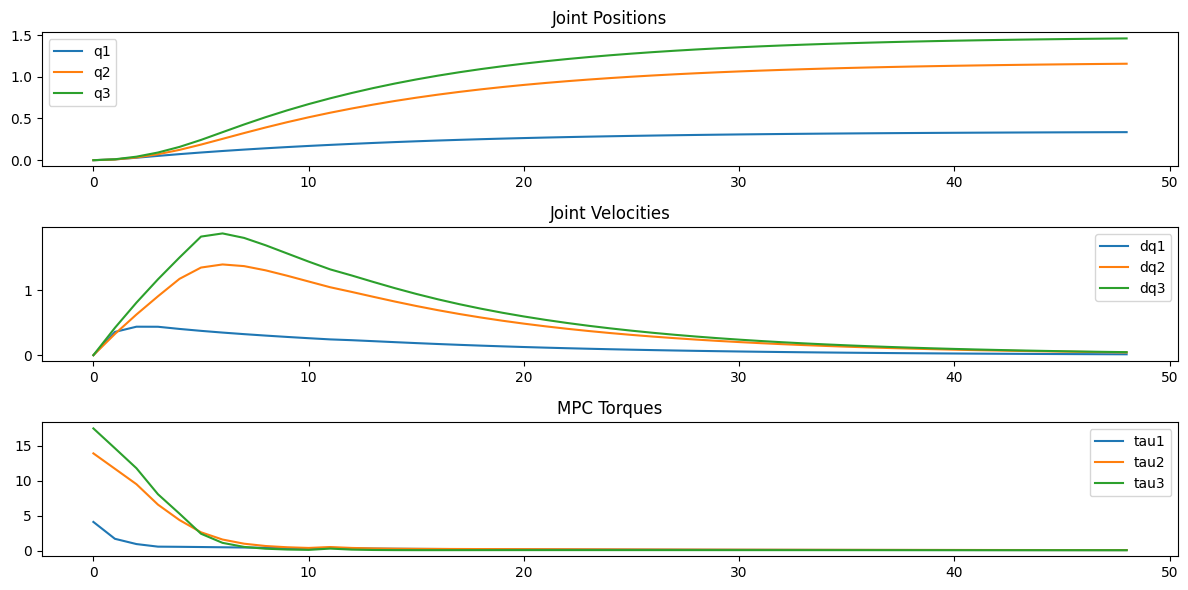

In [10]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()


## Model Architectures

In [11]:
class MLP(nn.Module):
    """Multi-Layer Perceptron with temporal window support"""
    def __init__(self, input_dim=33, hidden_dims=[128, 64], output_dim=3):
        """
        input_dim: for window_size=5, this is 5*6 + 3 = 33 (5 state windows + current target)
        """
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, 9)
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            out_packed, hn = self.gru(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, hn = self.gru(x) # (B, T_max, 3)

        out = self.fc(out)
        return out


## Training and Evaluation Functions

In [12]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3: # RNN
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)

            # Masking
            mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
            mask = mask.unsqueeze(-1).expand_as(targets)

            loss_raw = criterion(outputs, targets)
            loss = (loss_raw * mask).sum() / mask.sum()

        else: # MLP
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss_raw = criterion(outputs, targets)
            loss = loss_raw.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3: #RNN
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)

                # Masking
                mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
                mask = mask.unsqueeze(-1).expand_as(targets)

                loss_raw = criterion(outputs, targets)
                loss = (loss_raw * mask).sum() / mask.sum()

                # Filter predictions and targets for metrics
                # We flatten and remove padded values
                outputs_masked = outputs[mask].view(-1, 3)
                targets_masked = targets[mask].view(-1, 3)

                all_predictions.append(outputs_masked.cpu().numpy())
                all_targets.append(targets_masked.cpu().numpy())

            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss_raw = criterion(outputs, targets)
                loss = loss_raw.mean()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)
    mse_per_torque = mean_squared_error(targets, predictions, multioutput="raw_values")

    return {
        'loss': total_loss / num_batches,
        'mse': mse,
        'mae': mae,
        'direction_accuracy': da,
        'explained_variance': ev,
        'predictions': predictions,
        'targets': targets,
        'mse_per_torque': mse_per_torque
    }

In [13]:
def train_model(model_name, model, train_loader, test_loader, validation_loader,
                loss_type="mse", num_epochs=50, trial=0):
    if loss_type == "mse":
        criterion = nn.MSELoss(reduction='none')
    elif loss_type == "mae":
        criterion = nn.L1Loss(reduction='none')
    else:
        raise ValueError("loss_type must be 'mse' or 'mae'")

    # keep track of both for reporting, but only optimize 'criterion'
    monitor_mse = nn.MSELoss(reduction='none')
    monitor_mae = nn.L1Loss(reduction='none')

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    results = {
        'model_name': model_name,
        'loss_type': loss_type,
        'training_history': [],
        'best_results': None,
    }

    best_val_loss = float('inf')
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, validation_loader, criterion)

            epoch_time = time.time() - start_time

            pbar.set_postfix({
                "loss": f"{val_metrics['loss']:.4f}",
                "mse": f"{val_metrics['mse']:.4f}",
                "mae": f"{val_metrics['mae']:.4f}"
            })

            results['training_history'].append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_metrics['loss'],
                'val_mse': val_metrics['mse'],
                'val_mae': val_metrics['mae'],
                'val_da': val_metrics['direction_accuracy'],
                'val_ev': val_metrics['explained_variance'],
                'val_mse_per_torque': val_metrics['mse_per_torque'],
                'epoch_time': epoch_time
            })

            # save best model based on the chosen loss_type
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                results['best_results'] = val_metrics.copy()
                results['best_results'].pop('predictions', None)
                results['best_results'].pop('targets', None)
                model_output_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
                torch.save(model.state_dict(), model_output_path)

    except KeyboardInterrupt:
        print("\nInterrupted.")
    finally:
        # save the results of the best model on the test set
        best_model_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            final_test_metrics = evaluate(model, test_loader, criterion)

            final_test_metrics.pop('predictions', None)
            final_test_metrics.pop('targets', None)
            results['final_test_results'] = final_test_metrics

            print(f"Final Test MSE: {final_test_metrics['mse']:.5f}")
        else:
            print("failed opening best model")

        json_str = json.dumps(results, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, torch.Tensor)) else str(x))
        results_output_path = os.path.join(RESULTS_DIR, f'{model_name}_best_{loss_type}_{trial}_results.json')
        with open(results_output_path, 'w') as f:
            f.write(json_str)

    return results

# Experiment setup

In [14]:
def run_experiment_repeated(model_name, model_class, params, dataset_type, loss_type, n_runs=5, n_epochs=50, window_size=5):
    """Runs a specific configuration N times and aggregates metrics."""
    print(f"\n>>> EXPERIMENT: {model_name} | Loss: {loss_type} | Runs: {n_runs}")

    aggregated_metrics = {
        'mse': [], 'mae': [], 'direction_accuracy': [], 'explained_variance': []
    }

    for i in range(n_runs):
        print(f"   Run {i+1}/{n_runs}...", end=" ")

        train_dl, val_dl, test_dl = create_dataloaders(DATA_PATH, batch_size=64, dataset_type=dataset_type, window_size=window_size)
        model = model_class(**params).to(DEVICE)

        res = train_model(model_name, model, train_dl, val_dl, test_dl, loss_type=loss_type, num_epochs=n_epochs, trial=i+1)

        best = res['best_results']
        aggregated_metrics['mse'].append(best['mse'])
        aggregated_metrics['mae'].append(best['mae'])
        aggregated_metrics['direction_accuracy'].append(best['direction_accuracy'])
        aggregated_metrics['explained_variance'].append(best['explained_variance'])
        print(f"Done. (MSE: {best['mse']:.4f})")

    stats = {}
    for metric, values in aggregated_metrics.items():
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_std']  = np.std(values)

    print(f"   >>> {model_name} Finished. Avg MSE: {stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}")
    return stats


## Loss comparison

In [15]:
WINDOW_SIZE = 5  # Temporal context window for MLP

loss_configs = {
    'MLP': {'class': MLP, 'params': {'input_dim': WINDOW_SIZE * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp'},
    'GRU': {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn'},
}

loss_types = ['mse', 'mae']
loss_results = {}

for name, config in loss_configs.items():
    for loss in loss_types:
        run_name = f"{name}_{loss}"
        stats = run_experiment_repeated(
            model_name=run_name,
            model_class=config['class'],
            params=config['params'],
            dataset_type=config['dataset_type'],
            loss_type=loss,
            n_runs=5,
            n_epochs=50,
            window_size=WINDOW_SIZE
        )
        loss_results[run_name] = stats

print("\n=== PHASE 1 RESULTS SUMMARY ===")
print(f"{'Model Config':<20} | {'MSE (Mean ± Std)':<25} | {'MAE (Mean ± Std)':<25}")
print("-" * 75)
for name, stats in loss_results.items():
    mse_str = f"{stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}"
    mae_str = f"{stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}"
    print(f"{name:<20} | {mse_str:<25} | {mae_str:<25}")



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]



Final Test MSE: 2.17629
Done. (MSE: 2.0005)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]



Final Test MSE: 2.17629
Done. (MSE: 2.0005)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it, loss=0.3377, mse=1.9927, mae=0.3385]




>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]



Final Test MSE: 2.17629
Done. (MSE: 2.0005)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it, loss=0.3377, mse=1.9927, mae=0.3385]



Final Test MSE: 2.21617
Done. (MSE: 1.9927)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]



Final Test MSE: 2.17629
Done. (MSE: 2.0005)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it, loss=0.3377, mse=1.9927, mae=0.3385]



Final Test MSE: 2.21617
Done. (MSE: 1.9927)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [36:07<00:00, 43.36s/it, loss=0.3451, mse=1.9818, mae=0.3456] 


>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0296, mse=0.0298, mae=0.0605]



Final Test MSE: 0.01020
Done. (MSE: 0.0111)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it, loss=0.0263, mse=0.0256, mae=0.0557]



Final Test MSE: 0.01170
Done. (MSE: 0.0103)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:20<00:00,  4.00s/it, loss=0.0143, mse=0.0143, mae=0.0494]



Final Test MSE: 0.01050
Done. (MSE: 0.0118)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.0117, mse=0.0117, mae=0.0417]



Final Test MSE: 0.00959
Done. (MSE: 0.0117)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mse: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0218, mse=0.0220, mae=0.0440]



Final Test MSE: 0.01041
Done. (MSE: 0.0081)
   >>> MLP_mse Finished. Avg MSE: 0.0106 ± 0.0014

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0359, mse=0.0193, mae=0.0361]



Final Test MSE: 0.01302
Done. (MSE: 0.0148)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [11:05<00:00, 13.31s/it, loss=0.0308, mse=0.0113, mae=0.0308] 



Final Test MSE: 0.01247
Done. (MSE: 0.0113)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0334, mse=0.0152, mae=0.0336]



Final Test MSE: 0.01173
Done. (MSE: 0.0108)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:13<00:00,  5.07s/it, loss=0.0288, mse=0.0099, mae=0.0289]



Final Test MSE: 0.00964
Done. (MSE: 0.0084)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_mae: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, loss=0.0307, mse=0.0137, mae=0.0309]



Final Test MSE: 0.00929
Done. (MSE: 0.0097)
   >>> MLP_mae Finished. Avg MSE: 0.0110 ± 0.0021

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, loss=1.1854, mse=1.1903, mae=0.2658] 



Final Test MSE: 1.18292
Done. (MSE: 1.1903)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:03<00:00,  3.68s/it, loss=1.1071, mse=1.1154, mae=0.2672] 



Final Test MSE: 1.18254
Done. (MSE: 1.1154)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [03:01<00:00,  3.62s/it, loss=1.0525, mse=1.0774, mae=0.2609] 



Final Test MSE: 1.05541
Done. (MSE: 1.0774)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0811, mse=1.0972, mae=0.2566] 



Final Test MSE: 1.03884
Done. (MSE: 1.0972)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mse: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=1.0853, mse=1.0911, mae=0.2637]



Final Test MSE: 1.26335
Done. (MSE: 1.0911)
   >>> GRU_mse Finished. Avg MSE: 1.1143 ± 0.0399

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:42<00:00,  3.24s/it, loss=0.3290, mse=1.8912, mae=0.3294]



Final Test MSE: 2.07852
Done. (MSE: 1.8912)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.10s/it, loss=0.3393, mse=2.0144, mae=0.3381]



Final Test MSE: 2.07424
Done. (MSE: 2.0144)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:28<00:00,  2.98s/it, loss=0.3375, mse=2.0005, mae=0.3368]



Final Test MSE: 2.17629
Done. (MSE: 2.0005)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [02:25<00:00,  2.92s/it, loss=0.3377, mse=1.9927, mae=0.3385]



Final Test MSE: 2.21617
Done. (MSE: 1.9927)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_mae: 100%|██████████| 50/50 [36:07<00:00, 43.36s/it, loss=0.3451, mse=1.9818, mae=0.3456] 

Final Test MSE: 2.21224
Done. (MSE: 1.9818)
   >>> GRU_mae Finished. Avg MSE: 1.9761 ± 0.0437

=== PHASE 1 RESULTS SUMMARY ===
Model Config         | MSE (Mean ± Std)          | MAE (Mean ± Std)         
---------------------------------------------------------------------------
MLP_mse              | 0.0106 ± 0.0014           | 0.0439 ± 0.0035          
MLP_mae              | 0.0110 ± 0.0021           | 0.0302 ± 0.0015          
GRU_mse              | 1.1143 ± 0.0399           | 0.2629 ± 0.0038          
GRU_mae              | 1.9761 ± 0.0437           | 0.3377 ± 0.0051          


## Architecture comparison


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]



Final Test MSE: 0.47851
Done. (MSE: 0.4606)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]



Final Test MSE: 0.47851
Done. (MSE: 0.4606)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.4852, mse=0.4890, mae=0.1500]




>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]



Final Test MSE: 0.47851
Done. (MSE: 0.4606)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.4852, mse=0.4890, mae=0.1500]



Final Test MSE: 0.42391
Done. (MSE: 0.4890)
   >>> GRU_Wide Finished. Avg MSE: 0.4810 ± 0.0308



>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]



Final Test MSE: 0.47851
Done. (MSE: 0.4606)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.4852, mse=0.4890, mae=0.1500]



Final Test MSE: 0.42391
Done. (MSE: 0.4890)
   >>> GRU_Wide Finished. Avg MSE: 0.4810 ± 0.0308


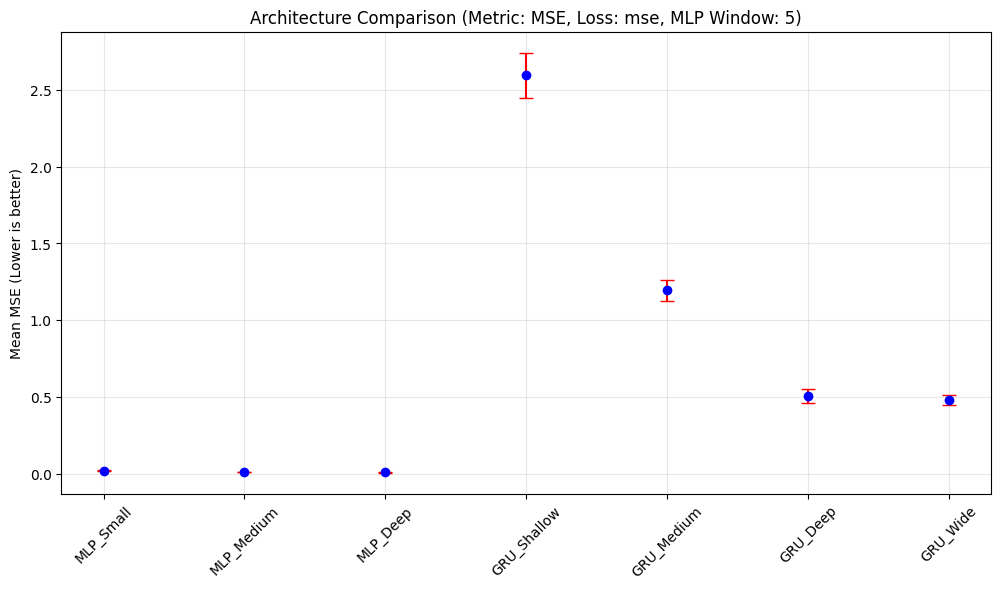


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0230, mse=0.0231, mae=0.0621]



Final Test MSE: 0.01725
Done. (MSE: 0.0162)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:05<00:00,  3.70s/it, loss=0.0230, mse=0.0230, mae=0.0676]



Final Test MSE: 0.02331
Done. (MSE: 0.0230)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.0216, mse=0.0217, mae=0.0707]



Final Test MSE: 0.01903
Done. (MSE: 0.0191)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it, loss=0.0159, mse=0.0159, mae=0.0519]



Final Test MSE: 0.01560
Done. (MSE: 0.0149)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Small: 100%|██████████| 50/50 [03:19<00:00,  3.98s/it, loss=0.0172, mse=0.0173, mae=0.0623]



Final Test MSE: 0.01815
Done. (MSE: 0.0173)
   >>> MLP_Small Finished. Avg MSE: 0.0181 ± 0.0028

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [04:01<00:00,  4.84s/it, loss=0.0174, mse=0.0174, mae=0.0521]



Final Test MSE: 0.01081
Done. (MSE: 0.0096)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:27<00:00,  4.16s/it, loss=0.0147, mse=0.0148, mae=0.0485]



Final Test MSE: 0.00854
Done. (MSE: 0.0096)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it, loss=0.0113, mse=0.0113, mae=0.0420]



Final Test MSE: 0.00959
Done. (MSE: 0.0082)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:33<00:00,  4.27s/it, loss=0.0111, mse=0.0111, mae=0.0465]



Final Test MSE: 0.00981
Done. (MSE: 0.0087)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Medium: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it, loss=0.0134, mse=0.0134, mae=0.0456]



Final Test MSE: 0.01191
Done. (MSE: 0.0110)
   >>> MLP_Medium Finished. Avg MSE: 0.0094 ± 0.0010

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it, loss=0.0119, mse=0.0119, mae=0.0367]



Final Test MSE: 0.00867
Done. (MSE: 0.0083)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it, loss=0.0092, mse=0.0092, mae=0.0376]



Final Test MSE: 0.00980
Done. (MSE: 0.0091)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it, loss=0.0163, mse=0.0164, mae=0.0383]



Final Test MSE: 0.00760
Done. (MSE: 0.0072)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0106, mse=0.0106, mae=0.0388]



Final Test MSE: 0.00897
Done. (MSE: 0.0089)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training MLP_Deep: 100%|██████████| 50/50 [04:21<00:00,  5.24s/it, loss=0.0137, mse=0.0137, mae=0.0415]



Final Test MSE: 0.00869
Done. (MSE: 0.0086)
   >>> MLP_Deep Finished. Avg MSE: 0.0084 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=2.6645, mse=2.6650, mae=0.4178] 



Final Test MSE: 2.67907
Done. (MSE: 2.6650)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it, loss=2.4828, mse=2.4867, mae=0.4041] 



Final Test MSE: 2.64735
Done. (MSE: 2.4867)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.8198, mse=2.8446, mae=0.4338] 



Final Test MSE: 2.47296
Done. (MSE: 2.8446)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it, loss=2.5318, mse=2.5544, mae=0.4046] 



Final Test MSE: 2.67435
Done. (MSE: 2.5544)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172


Training GRU_Shallow: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it, loss=2.4405, mse=2.4222, mae=0.3972] 



Final Test MSE: 2.66161
Done. (MSE: 2.4222)
   >>> GRU_Shallow Finished. Avg MSE: 2.5946 ± 0.1486

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=1.3425, mse=1.3137, mae=0.2882] 



Final Test MSE: 1.14378
Done. (MSE: 1.3137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1956, mse=1.2095, mae=0.2669] 



Final Test MSE: 1.19389
Done. (MSE: 1.2095)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:26<00:00,  2.94s/it, loss=1.1578, mse=1.1806, mae=0.2647] 



Final Test MSE: 1.22550
Done. (MSE: 1.1806)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=1.1864, mse=1.1488, mae=0.2629] 



Final Test MSE: 1.00327
Done. (MSE: 1.1488)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Medium: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it, loss=1.1321, mse=1.1195, mae=0.2490] 



Final Test MSE: 1.06968
Done. (MSE: 1.1195)
   >>> GRU_Medium Finished. Avg MSE: 1.1944 ± 0.0669

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:36<00:00,  5.53s/it, loss=0.4740, mse=0.4788, mae=0.2234] 



Final Test MSE: 0.53227
Done. (MSE: 0.4788)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:53<00:00,  5.87s/it, loss=0.4762, mse=0.4741, mae=0.2043] 



Final Test MSE: 0.47365
Done. (MSE: 0.4741)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.6113, mse=0.5995, mae=0.2389] 



Final Test MSE: 0.54092
Done. (MSE: 0.5996)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [05:30<00:00,  6.60s/it, loss=0.5246, mse=0.5091, mae=0.2230] 



Final Test MSE: 0.48593
Done. (MSE: 0.4978)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Deep: 100%|██████████| 50/50 [04:57<00:00,  5.95s/it, loss=0.4937, mse=0.4826, mae=0.2152] 



Final Test MSE: 0.53546
Done. (MSE: 0.4826)
   >>> GRU_Deep Finished. Avg MSE: 0.5066 ± 0.0472

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:18<00:00,  6.37s/it, loss=0.5203, mse=0.5009, mae=0.1442]



Final Test MSE: 0.57713
Done. (MSE: 0.5009)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:10<00:00,  6.22s/it, loss=0.5290, mse=0.5210, mae=0.1572]



Final Test MSE: 0.51885
Done. (MSE: 0.5210)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it, loss=0.4201, mse=0.4334, mae=0.1432]



Final Test MSE: 0.52878
Done. (MSE: 0.4334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.4607, mse=0.4606, mae=0.1482]



Final Test MSE: 0.47851
Done. (MSE: 0.4606)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172
Split sizes: Train=1372, Val=171, Test=172


Training GRU_Wide: 100%|██████████| 50/50 [05:03<00:00,  6.08s/it, loss=0.4852, mse=0.4890, mae=0.1500]



Final Test MSE: 0.42391
Done. (MSE: 0.4890)
   >>> GRU_Wide Finished. Avg MSE: 0.4810 ± 0.0308


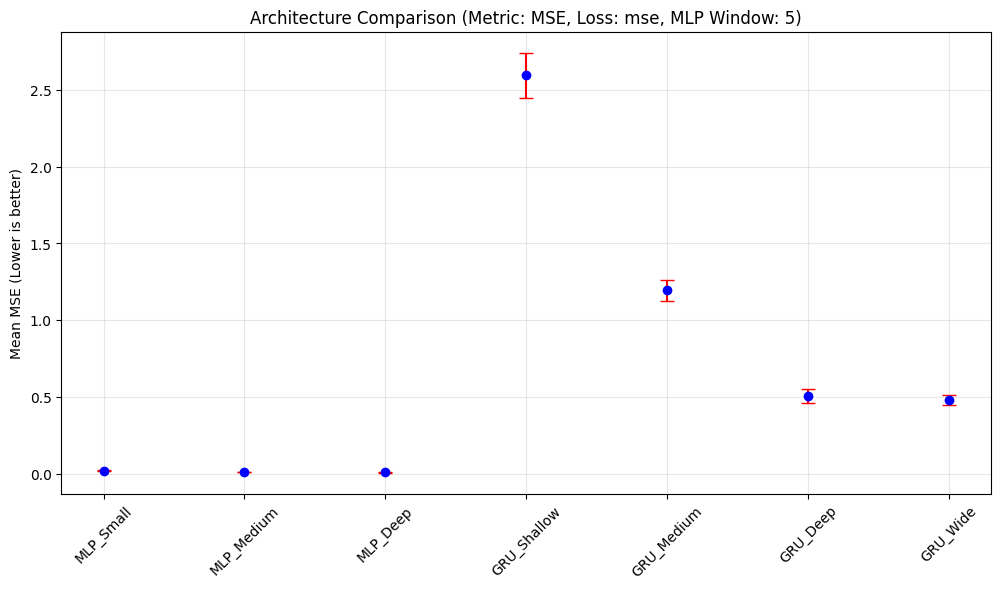


=== PHASE 2 RANKING ===
Architecture  Mean MSE  Std Dev
    MLP_Deep  0.008421 0.000674
  MLP_Medium  0.009393 0.000956
   MLP_Small  0.018103 0.002814
    GRU_Wide  0.480966 0.030808
    GRU_Deep  0.506614 0.047188
  GRU_Medium  1.194425 0.066864
 GRU_Shallow  2.594570 0.148609


In [17]:
BEST_LOSS = 'mse'
WINDOW_SIZE = 5  # Temporal context window for MLP

archi_configs = {
    'MLP_Small':   {'class': MLP, 'params': {'input_dim': WINDOW_SIZE * 6 + 3, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp'},
    'MLP_Medium':  {'class': MLP, 'params': {'input_dim': WINDOW_SIZE * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp'}, # Baseline
    'MLP_Deep':    {'class': MLP, 'params': {'input_dim': WINDOW_SIZE * 6 + 3, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp'},

    'GRU_Shallow': {'class': GRU, 'params': {'hidden_dim': 64,  'num_layers': 1}, 'dataset_type': 'rnn'},
    'GRU_Medium':  {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn'}, # Baseline
    'GRU_Deep':    {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 4}, 'dataset_type': 'rnn'},
    'GRU_Wide':    {'class': GRU, 'params': {'hidden_dim': 256, 'num_layers': 2}, 'dataset_type': 'rnn'},
}

archi_results = {}

for name, config in archi_configs.items():
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type=BEST_LOSS,
        n_runs=5,
        n_epochs=50,
        window_size=WINDOW_SIZE
    )
    archi_results[name] = stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_viz = []
for name, stats in archi_results.items():
    data_viz.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df = pd.DataFrame(data_viz)

plt.figure(figsize=(12, 6))
# Plot with Error Bars
plt.errorbar(x=df['Architecture'], y=df['Mean MSE'], yerr=df['Std Dev'], fmt='o', capsize=5, ecolor='red', color='blue')
plt.title(f"Architecture Comparison (Metric: MSE, Loss: {BEST_LOSS}, MLP Window: {WINDOW_SIZE})")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

print("\n=== PHASE 2 RANKING ===")
df_sorted = df.sort_values(by='Mean MSE')
print(df_sorted.to_string(index=False))
